# Thesis notebook


### Setup and prep
In this section we check that we are using the correct version of Python (3.8), and we import some of the basic libraries which we will need throughout the notebook.

In [ ]:
!python --version

In [1]:
import json
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import collections

## Ranking Queries

In [2]:
from pyserini.index import IndexReader
index_reader = IndexReader('data/indexes/indexes/lucene-index')
len_C = index_reader.stats()['total_terms']

In [3]:
import pandas as pd

with open("queries.json", "r") as file:
    queries = pd.DataFrame(json.load(file))

assert( set(queries.columns) == set(['id', 'keywords', 'title', 'rel_docs', 'URL']) )

# transform string to list
queries["rel_docs"]= list(map(lambda x: x.strip('][').split(', '), queries["rel_docs"]))

In [4]:
print(queries)

      id                                           keywords  \
0     84  ['cultivated', 'agricultural', 'maize', 'corn'...   
1    111  ['reptile', 'lizard', 'salamander', 'fossil', ...   
2    265  ['astronomer', 'astronomy', 'astrophysicist', ...   
3    323  ['aviation', 'airfield', 'airport', 'aerospace...   
4    396  ['actor', 'cast', 'screenwriter', 'filmmaker',...   
5    397  ['singer', 'musician', 'songwriter', 'guitaris...   
6    403  ['philosopher', 'scientist', 'mathematician', ...   
7    409  ['bird', 'island', 'plumage', 'falconidae', 'p...   
8    426  ['novel', 'trilogy',  'paperback', 'miniseries...   
9    475  [ 'financier', 'businessman', 'roosevelt', 'ri...   
10   594  ['pharmacology', 'sulfur', 'sulfuric', 'sulfur...   
11   620  ['charlemagne', 'cathedral', 'pope', 'babylon'...   
12   666  ['hamburg', 'london', 'berlin', 'kyiv', 'riga'...   
13   677  ['composer', 'musician', 'piano', 'libretto', ...   
14   724  ['programming', 'java', 'computing', 'compile

In [6]:
# check type
assert(type(queries["rel_docs"][0]) == list)

In [5]:
from pyserini.search.lucene import LuceneSearcher
import json

def search(s, e, k=500, verbose=True, expand= False):
    # s is our starting query
    # e is our final query
    # k is the number of results we want to gather for each query

    ###
    # itterate over rows s until e
    # extract information from our queries table
    # return the list of combined results and relevancy labels
    ###
    
    results = []
    searcher = LuceneSearcher("data/indexes/indexes/lucene-index")
    fairness = LuceneSearcher("data/indexes/indexes/lucene-index-fairness")

    for index, row in queries[s:e].iterrows():
        project = row["title"]
        q   = row["keywords"]
        r   = row["rel_docs"]

        # if expand == True:
        #     q = ' '.join(expand_query(row["keywords"], project))
                    
        if verbose:
            print(project)
            
        topH = searcher.search(q, k=k)

        results.append( ([doc for doc in topH], r) )
        
    return results

C:\Users\marta\anaconda3\envs\pyserini\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import numpy as np 
import math

def get_relevancy_labels(ranking, rel_judge):
    return [1 if x.docid in rel_judge else 0 for x in ranking]

def DCG(query_relevancy_labels, k):
    l = len(query_relevancy_labels)
    return np.sum(
        [0 if j == 0 else i / j for i, j in zip(query_relevancy_labels[:k], [math.log(2+i,2) for i in range(min(k, l))])]
    )
    
def NDCG(query_relevancy_labels, k):
    #ideal = np.sort(query_relevancy_labels)[::-1]
    #print(ideal)
    ideal = [1]*k
    return 0 if DCG(ideal, k) == 0 else DCG(query_relevancy_labels, k)/DCG(ideal, k)

# assert np.isclose(NDCG(np.array([0,0,0,0,0], dtype=int), k=5), 0)
# assert np.isclose(NDCG(np.array([0,0,0,0,1], dtype=int), k=5), 0.38685280723454163)
# assert np.isclose(NDCG(np.array([0,1,1,1,1], dtype=int), k=4), 0.6096199500078984)
# assert np.isclose(NDCG(np.array([0, 1], dtype=int), k=5), 0.6309297535714575)

In [7]:
import math 

def J(document_topics, topic, alpha=0.5):
    d = dict(document_topics)
    if topic in d.keys():
        return d[topic] #should this be alpha?
    else:
        return 0

def r_i(i, clustering_topics_so_far):
    return sum([ J(j, i) for j in clustering_topics_so_far])
    
def gain(k, clustering_topics, alpha = 0.5, n_topics = 10):
    # gain for document k, with 
    cluster_topics = list(clustering_topics)[:]
    d_k = cluster_topics[k]
    k_prev = cluster_topics[:k]
    if k == 0:
        return  sum([J(d_k, i) for i in range(n_topics)])
    else:
        #print( [(J(d_k, i), r_i(i, k_prev)) for i in range(n_topics)])
        return sum(
            [ J(d_k, i) * (1 - alpha)**(r_i(i, k_prev)) for i in range(n_topics)]
        )

def DCG_2(clustering_topics, k):
    return sum( 
        [ 
            (gain(k, clustering_topics[:k+1])/ (math.log2(2 + k)))
            for k in range(min( len(clustering_topics), k))
        ]
    )

def get_max_gain_element(current_list, items):
    max_gain = 0
    max_index = None
    
    current_list = current_list[:]
    k = len(current_list) 
    
    for i, item in enumerate(items):
        lst = current_list[:]
        lst.append(item)
        new_gain = gain(k, lst)
        if new_gain > max_gain:
            max_index = i
            max_gain = new_gain

    return max_index

def ideal(clustering_topics, k):
    clustering_topics = clustering_topics[:]
    ideal = []
    size = min(len(clustering_topics), k)
    while len(ideal) < size:
        max_index = get_max_gain_element(ideal, clustering_topics)
        max_element = clustering_topics.pop(max_index)
        #print(gain_list, max_index, max_element)
        ideal.append(max_element)
    return ideal


def NDCG_2(clustering_topics, k):
    return DCG_2(clustering_topics, k)/DCG_2(ideal(clustering_topics, k), k)

def get_topic_info_reranking(clustering_topics, ranking, reranking):
    rr =  [x.docid for x in ranking]
    return [ clustering_topics[rr.index(y)] for y in [x.docid for x in reranking]] 

In [8]:
results = search(0, 5) 
results2 = search(0, 5, expand=True) 

for (result, rel_judge), (result2, rel_judge2) in zip(results, results2):
    query_relevancy_labels = get_relevancy_labels(result, rel_judge)
    query_relevancy_labels2 = get_relevancy_labels(result2, rel_judge2)
    print(NDCG(query_relevancy_labels, 500))
    print(NDCG(query_relevancy_labels2, 500))

Agriculture
Amphibians and Reptiles
Astronomy
Aviation
Biography/WikiProject Actors and Filmmakers
Agriculture
Amphibians and Reptiles
Astronomy
Aviation
Biography/WikiProject Actors and Filmmakers
0.43301057140649213
0.43301057140649213
0.5796176244972758
0.5796176244972758
0.7367988169552996
0.7367988169552996
0.8857038233406795
0.8857038233406795
0.6385168742336628
0.6385168742336628


In [9]:
ranking1 = results[0][0]
relevance_1 = results[0][1]

print(sum(get_relevancy_labels(ranking1[:100], relevance_1)))
print(sum(get_relevancy_labels(ranking1[:50], relevance_1)))
print(sum(get_relevancy_labels(ranking1[:10], relevance_1)))

54
28
7


#### Conclusions from default ranking
As we can see by the result, of the 500 documents we put in our top 100, 54 are relevant according to our relevance judgments. So it works okay-ish but definitely it is not great. By inspecting the results for 50 and 10 as well we can observe that about 50% of our results at any point will be relevant, but we do not necessarily have more relevant documents near the top. Thus, our ranking method could definitely improve.

## Fairness
In this section we setup our lookup table for the fairness attributes.

In [17]:
from MetricInputs import *

C:\Users\marta\Thesis\trec2022-fair-public\MetricInputs.py:49: UserWarning: No DATA_MODE specified, assuming ‘train’
  warnings.warn('No DATA_MODE specified, assuming ‘train’')


data/trec_2022_train_reldocs.jsonl


In [18]:
gender_align

gender,@UNKNOWN,female,male,NB
page_id,,,,
12,1.0,0.0,0.0,0.0
25,1.0,0.0,0.0,0.0
39,1.0,0.0,0.0,0.0
290,1.0,0.0,0.0,0.0
303,1.0,0.0,0.0,0.0
...,...,...,...,...
70194419,1.0,0.0,0.0,0.0
70194480,1.0,0.0,0.0,0.0
70194481,1.0,0.0,0.0,0.0


In [19]:
gender_tgt

female    0.495
male      0.495
NB        0.010
Name: gender, dtype: float64

In [20]:
def get_fairness(ranking):
    ranking_docids = [doc.docid for doc in ranking]
    resulting_fairness = gender_align.loc[ gender_align.index.isin([eval(x) for x in ranking_docids])]

    return resulting_fairness

def get_fairness2(ranking_docids):
    resulting_fairness = gender_align.loc[ gender_align.index.isin([eval(x) for x in ranking_docids])]

    return resulting_fairness


ranking1_fairness = get_fairness(ranking1)
ranking1_fairness

gender,@UNKNOWN,female,male,NB
page_id,,,,
627,1.0,0.0,0.0,0.0
1064,1.0,0.0,0.0,0.0
1542,1.0,0.0,0.0,0.0
2175,1.0,0.0,0.0,0.0
4487,1.0,0.0,0.0,0.0
...,...,...,...,...
64678597,1.0,0.0,0.0,0.0
65542369,1.0,0.0,0.0,0.0
66316091,1.0,0.0,0.0,0.0


In [ ]:
# fairness_df = pd.DataFrame()

# fairness_df["gender"] = gender_align.idxmax(axis=1)
# fairness_df["page_id"] = gender_align.index

In [ ]:
import pandas as pd

#fairness_df = pd.read_json("fairness.json", lines=True)
gender_align.head()

In [ ]:
len(gender_align.index)

In [ ]:
#fairness_df.gender = fairness_df.gender.apply(lambda x: x[0] if len(x) > 0 else "@UNKNOWN")
#fairness_df.page_id = fairness_df.page_id.apply(lambda x: str(x))

In [ ]:
gender_align.sum()

In [ ]:
gender_align.mean()

In [ ]:
term = 'played'

# Look up its document frequency (df) and collection frequency (cf).
df, cf = index_reader.get_term_counts(term)

analyzed_form = index_reader.analyze(term)
print(f'Analyzed form of term "{analyzed_form[0]}": df={df}, cf={cf}')

In [ ]:
def len_doc(d):
    document = index_reader.get_document_vector(d)
    len_d = sum(document.values())
    return len_d  

def coll_freq(t):
    cf = index_reader.get_term_counts(t)[1]
    return cf

def term_freq(t, d):
    document = index_reader.get_document_vector(d)
    tf = document[t] if t in document.keys() else 0
    return tf

### BASIC TESTS TO SEE OUR INDEXER WORKS ###
assert(len_doc("12") == 4421)
assert(coll_freq("wikipedia") == 41558)
assert(term_freq("communist", "12") == 7)

## Query expansion

In [23]:
import sys
from pathlib import Path
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import json
from natural.size import binarysize

In [24]:
from tqdm.auto import tqdm
tqdm.pandas(leave=False)

In [36]:
page_path = Path(f'data/train_topics_meta.jsonl')
page_file_size = page_path.stat().st_size
binarysize(page_file_size)

'19.50 MiB'

In [37]:
from itertools import chain
from nltk.corpus import wordnet
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def get_synonyms(word):
    synonyms = wordnet.synsets(word)
    return list(set(chain.from_iterable([word.lemma_names() for word in synonyms])))

def string_to_list(str_lst):
    if not isinstance(str_lst, list): 
        return str_lst.replace("'", "").strip("][").split(", ")
    else:
        return lst
    
def get_synsets(inp):
    synsets = []
    words = [
                word 
                for word in inp.split(" ")
                if not word in STOPWORDS
            ]
    #print(words)
    for word in words:
        synsets += wordnet.synsets(word)
    #print(synsets)
    return synsets

In [38]:
from nltk.metrics import binary_distance
from itertools import product


def expand_query(q, title):
    wordlist_old = string_to_list(q)
    wordlist = list(set(sum([get_synonyms(w) + [w] for w in wordlist_old], [])))
    
    similarities = []
    s2 = get_synsets(title)
    
    for word in wordlist:
        sims = []
        s1 = get_synsets(word)
        for sense1, sense2 in product(s1, s2):
            sims.append(sense1.path_similarity(sense2))

        if (len(sims)>0):
            avgsims = sum(sims)/len(sims)
            similarities.append(avgsims)
        else:
            similarities.append(-1)

    wordsims = zip(wordlist, similarities)
    result = wordlist if s2 == [] else [word[0] for word in wordsims if word[1]>=0.05]

    return result


## Clustering

Data exploration for a new searcher

In [ ]:
searcher = LuceneSearcher("indexes/lucene-index")

results = search(1, 2) 
documents = list(
    map(
        lambda x: json.loads(searcher.doc(x.docid).raw())['contents'], results[0][0]
    )
)

In [ ]:
for result, rel_judge in results:
    query_relevancy_labels = get_relevancy_labels(result, rel_judge)
    print(NDCG(query_relevancy_labels, 100))

In [ ]:
print( documents[0]  )

### LDA

#### Setup and prep

In [20]:
import re
data = pd.DataFrame(documents, columns=["text"])
def preprocess_text(text):
    text = re.sub('\s+', ' ', text)  # Remove extra spaces
    text = re.sub('\S*@\S*\s?', '', text)  # Remove emails
    text = re.sub('\'', '', text)  # Remove apostrophes
    text = re.sub('[^a-zA-Z]', ' ', text)  # Remove non-alphabet characters
    text = text.lower()  # Convert to lowercase
    return text

data['cleaned_text'] = data["text"].apply(preprocess_text)

In [21]:
import gensim
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

# Tokenize and remove stopwords
def tokenize(text):
    tokens = gensim.utils.simple_preprocess(text, deacc=True)
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

data['tokens'] = data['cleaned_text'].apply(tokenize)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
!python -m spacy download en

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.1/12.8 MB 1.0 MB/s eta 0:00:13
     - -------------------------------------- 0.5/12.8 MB 4.1 MB/s eta 0:00:03
     --- ------------------------------------ 1.1/12.8 MB 6.5 MB/s eta 0:00:02
     ----- ---------------------------------- 1.9/12.8 MB 8.5 MB/s eta 0:00:02
     -------- ------------------------------- 2.7/12.8 MB 10.1 MB/s eta 0:00:02
     ----------- ---------------------------- 3.7/12.8 MB 11.9 MB/s eta 0:00:01
     -------------- ------------------------- 4.5/12.8 MB 12.4 MB/s eta 0:00:01
     ----------------- ---------------------- 5.7/12.8 MB 14.0 MB/s eta 0:00:01
     --------------------- ------------------ 6.9/12.8 MB 15.2 MB/s eta 0:00:01
     -------------------------- ------------- 8.4/12.8 MB 16.9 MB/s eta 0:00:01
     ------------------------------ --------- 9.9/12.8 MB 18

In [23]:
import spacy

# Load spaCy model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatize(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]

data['lemmas'] = data['tokens'].apply(lemmatize)

In [24]:
import gensim.corpora as corpora

# Create dictionary and corpus
id2word = corpora.Dictionary(data['lemmas'])
texts = data['lemmas']
corpus = [id2word.doc2bow(text) for text in texts]

In [25]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

In [26]:
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.028*"millet" + 0.023*"taiwan" + 0.017*"sorghum" + 0.013*"taiwanese" + 0.013*"soybean" + 0.011*"soy" + 0.010*"japanese" + 0.007*"proso" + 0.006*"indian" + 0.006*"india"')
(1, '0.013*"agricultural" + 0.011*"production" + 0.011*"agriculture" + 0.010*"farm" + 0.009*"land" + 0.009*"crop" + 0.008*"large" + 0.008*"ton" + 0.008*"million" + 0.006*"area"')
(2, '0.003*"kcal" + 0.000*"macroscopic" + 0.000*"guerrilla" + 0.000*"eucommia" + 0.000*"alga" + 0.000*"yohimbee" + 0.000*"kharif" + 0.000*"intercropping" + 0.000*"rabi" + 0.000*"parenthese"')
(3, '0.013*"make" + 0.011*"dish" + 0.011*"cuisine" + 0.011*"food" + 0.009*"meat" + 0.008*"also" + 0.008*"serve" + 0.008*"use" + 0.007*"rice" + 0.006*"eat"')
(4, '0.120*"virus" + 0.049*"bee" + 0.023*"honey" + 0.015*"hive" + 0.012*"mosaic" + 0.011*"queen" + 0.010*"colony" + 0.010*"yellow" + 0.009*"leaf" + 0.009*"worker"')
(5, '0.030*"corn" + 0.024*"mexico" + 0.018*"chile" + 0.017*"de" + 0.017*"tamale" + 0.014*"mexican" + 0.012*"spanish" + 0.011*"avoc

In [27]:
from gensim.models import CoherenceModel

# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data['lemmas'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.49208607017008826


In [28]:
rankedClusters = list(
    map(lambda d: 
        d[[y for (x,y) in d].index(max([y for (x,y) in d]))][0], lda_model.get_document_topics(corpus))
)
print(rankedClusters)

[7, 9, 1, 3, 9, 1, 9, 9, 9, 1, 1, 9, 9, 3, 1, 9, 1, 3, 9, 1, 9, 9, 9, 9, 9, 9, 7, 1, 1, 6, 1, 1, 9, 3, 3, 1, 3, 3, 3, 1, 9, 9, 9, 7, 9, 3, 3, 9, 6, 1, 9, 3, 1, 1, 1, 9, 3, 1, 3, 3, 9, 3, 9, 3, 1, 9, 9, 3, 9, 9, 3, 3, 9, 9, 9, 3, 9, 9, 1, 1, 9, 3, 9, 9, 1, 9, 3, 1, 3, 1, 1, 1, 9, 9, 9, 9, 3, 1, 1, 3, 9, 3, 3, 9, 9, 9, 3, 3, 9, 3, 1, 3, 1, 1, 9, 9, 3, 3, 9, 3, 9, 9, 1, 9, 3, 3, 9, 9, 3, 3, 3, 1, 9, 3, 1, 9, 9, 9, 3, 3, 3, 3, 3, 9, 3, 9, 9, 1, 9, 9, 9, 9, 1, 1, 1, 9, 9, 9, 9, 1, 3, 9, 3, 9, 3, 1, 9, 3, 3, 3, 9, 9, 9, 9, 9, 7, 3, 7, 9, 9, 9, 3, 1, 9, 9, 1, 3, 1, 3, 9, 9, 3, 9, 9, 3, 1, 1, 1, 9, 1, 3, 9, 3, 1, 7, 9, 3, 1, 3, 1, 6, 9, 9, 9, 3, 3, 9, 3, 9, 3, 1, 9, 1, 1, 9, 3, 1, 1, 3, 9, 1, 1, 1, 3, 3, 3, 3, 4, 9, 9, 3, 3, 3, 9, 3, 3, 3, 1, 3, 3, 1, 9, 9, 1, 9, 9, 3, 1, 9, 9, 1, 3, 1, 9, 1, 9, 3, 3, 1, 9, 9, 3, 3, 1, 1, 1, 9, 9, 9, 9, 3, 9, 9, 3, 9, 9, 3, 1, 1, 3, 3, 9, 9, 1, 3, 9, 9, 9, 3, 9, 1, 1, 9, 3, 9, 9, 6, 9, 3, 9, 9, 3, 9, 9, 3, 3, 7, 1, 1, 9, 3, 3, 1, 3, 9, 9, 9, 1, 3, 9, 9, 9, 3, 

#### Final model

In [29]:
import re
import gensim
import nltk
from nltk.corpus import stopwords
import spacy
import gensim.corpora as corpora

# Download NLTK stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

def get_clustering(result, ranking_index = 0, searcher = LuceneSearcher("indexes/lucene-index"), n_clusters = 10):
    def preprocess_text(text):
        text = re.sub('\s+', ' ', text)  # Remove extra spaces
        text = re.sub('\S*@\S*\s?', '', text)  # Remove emails
        text = re.sub('\'', '', text)  # Remove apostrophes
        text = re.sub('[^a-zA-Z]', ' ', text)  # Remove non-alphabet characters
        text = text.lower()  # Convert to lowercase
        return text
    def tokenize(text):
        tokens = gensim.utils.simple_preprocess(text, deacc=True)
        tokens = [token for token in tokens if token not in stop_words]
        return tokens

    def lemmatize(tokens):
        doc = nlp(" ".join(tokens))
        return [token.lemma_ for token in doc]
    
    documents = list(
        map(
            lambda x: json.loads(searcher.doc(x.docid).raw())['contents'], result
        )
    )

    data = pd.DataFrame(documents, columns=["text"])
    data['cleaned_text'] = data["text"].apply(preprocess_text)

    # Load spaCy model
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    data['tokens'] = data['cleaned_text'].apply(tokenize)
    data['lemmas'] = data['tokens'].apply(lemmatize)

    # Create dictionary and corpus
    id2word = corpora.Dictionary(data['lemmas'])
    texts = data['lemmas']
    corpus = [id2word.doc2bow(text) for text in texts]

    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics= n_clusters, 
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)

    rankedClusters = list(
    map(lambda d: 
        d[[y for (x,y) in d].index(max([y for (x,y) in d]))][0], lda_model.get_document_topics(corpus))
    )

    lda_model.print_topics()
    
    x = corpora.Dictionary(lemmatize(tokenize(preprocess_text(
        ' '.join(queries.iloc[ranking_index]["keywords"])
    ))))
    
    cluster_preferences = lda_model[ id2word.doc2bow(x)]

    return rankedClusters, cluster_preferences, lda_model.get_document_topics(corpus, minimum_probability=0)

results = search(1, 2, k=10) 
print(get_clustering(results[0][0]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Amphibians and Reptiles
([1, 5, 7, 7, 2, 1, 1, 7, 7, 1], [(0, 0.04097463), (1, 0.3361371), (2, 0.07652795), (3, 0.041625153), (4, 0.054759018), (5, 0.08609392), (6, 0.058024812), (7, 0.20282887), (8, 0.062329423), (9, 0.040699117)], <gensim.interfaces.TransformedCorpus object at 0x000001D6900A2460>)


In [30]:
def preprocess_text(text):
    text = re.sub('\s+', ' ', text)  # Remove extra spaces
    text = re.sub('\S*@\S*\s?', '', text)  # Remove emails
    text = re.sub('\'', '', text)  # Remove apostrophes
    text = re.sub('[^a-zA-Z]', ' ', text)  # Remove non-alphabet characters
    text = text.lower()  # Convert to lowercase
    return text
def tokenize(text):
    tokens = gensim.utils.simple_preprocess(text, deacc=True)
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

def lemmatize(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]

documents = list(
    map(
        lambda x: json.loads(searcher.doc(x.docid).raw())['contents'], result
    )
)

data = pd.DataFrame(documents, columns=["text"])
data['cleaned_text'] = data["text"].apply(preprocess_text)

# Load spaCy model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

data['tokens'] = data['cleaned_text'].apply(tokenize)
data['lemmas'] = data['tokens'].apply(lemmatize)

# Create dictionary and corpus
id2word = corpora.Dictionary(data['lemmas'])
texts = data['lemmas']
corpus = [id2word.doc2bow(text) for text in texts]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=20, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

In [31]:
for x in lda_model.get_document_topics(corpus):
    print(x)

[(6, 0.24182001), (7, 0.43836877), (12, 0.07312418), (18, 0.24066472)]
[(3, 0.105352454), (6, 0.09248289), (10, 0.4601462), (12, 0.04702697), (13, 0.019459132), (18, 0.2686661)]
[(3, 0.01705686), (6, 0.23133528), (7, 0.016289668), (11, 0.20917284), (12, 0.109480694), (18, 0.41612244)]
[(3, 0.016480843), (6, 0.16563576), (7, 0.138052), (12, 0.26947948), (18, 0.35573897), (19, 0.041772228)]
[(3, 0.06179299), (6, 0.11473547), (7, 0.38866153), (12, 0.14369452), (18, 0.28247792)]
[(6, 0.016976986), (7, 0.026032135), (10, 0.37261626), (12, 0.4827734), (18, 0.10123922)]
[(6, 0.52266705), (7, 0.34931958), (12, 0.04387133), (18, 0.079965055)]
[(3, 0.030010873), (12, 0.19513766), (15, 0.6357703), (18, 0.1288881)]
[(6, 0.010451168), (7, 0.04043478), (12, 0.02007475), (18, 0.92877954)]
[(3, 0.04044689), (6, 0.57032007), (18, 0.37968668)]
[(7, 0.10605166), (12, 0.060786847), (18, 0.81632894)]
[(6, 0.8633463), (12, 0.03446649), (18, 0.09428466)]
[(6, 0.5381812), (7, 0.043822974), (10, 0.04329792), (

In [32]:
lda_model.print_topics()
x = corpora.Dictionary(lemmatize(tokenize(preprocess_text(
    ' '.join(queries.iloc[0]["keywords"])
))))
print(x)
lda_model[ id2word.doc2bow(x)]

Dictionary<0 unique tokens: []>


[(3, 0.021249663),
 (4, 0.018303305),
 (6, 0.20115791),
 (7, 0.08282494),
 (10, 0.045066234),
 (12, 0.1323505),
 (15, 0.025362454),
 (18, 0.42782268)]

## Clustering Based reranking

In [33]:
searcher = LuceneSearcher("indexes/lucene-index")

results = search(0, 10, k=500) 
documents = list(
    map(
        lambda x: json.loads(searcher.doc(x.docid).raw())['contents'], results[0][0]
    )
)

Agriculture
Amphibians and Reptiles
Astronomy
Aviation
Biography/WikiProject Actors and Filmmakers
Biography/WikiProject Musicians
Biography/science and academia work group
Birds
Books
Business


In [34]:
# old_ndcg = []

# for ranking, rel_judge in results:
#     fairness_ranking_i = get_fairness(ranking)[:100]
#     print(collections.Counter(list(fairness_ranking_i["gender"])))

#     query_relevancy_labels = get_relevancy_labels(ranking, rel_judge)
#     ndcg_i = NDCG(query_relevancy_labels, 100)
#     old_ndcg.append(ndcg_i)
#     print(ndcg_i)
#     print()

In [35]:
# result7 = results[7]
# ranking7 = [x.docid for x in result7[0]]
# relevance7 = queries.iloc[7]["rel_docs"]

# print(all([document in relevance7 for document in ranking7]))
# print()
# for i in range(45):
#     print( len(queries.iloc[i]["rel_docs"]) )

### Round Robin Clusters

In [36]:
import copy 

import itertools

def roundrobin(*iterables):
    "Visit input iterables in a cycle until each is exhausted."
    # roundrobin('ABC', 'D', 'EF') → A D E B F C
    # Algorithm credited to George Sakkis
    iterators = map(iter, iterables)
    for num_active in range(len(iterables), 0, -1):
        iterators = itertools.cycle(itertools.islice(iterators, num_active))
        yield from map(next, iterators)
        
def roundRobinWithClusters(ranking, clusters, cluster_preferences, n_clusters=10, l=100):
    order = list(map(lambda x: x[0], sorted(cluster_preferences, key=lambda x: x[1])[::-1]))
    ranking = ranking[:]
    clusters = clusters[:]
    cluster_list = [ [(ranking[x], clusters[x])  for x in range(len(ranking)) if clusters[x]==i] for i in range(n_clusters)]

    ###
    #    Order clusters in terms of BM25
    cluster_list = list(
            map(
                lambda x: sorted(x, key=lambda x: x[0].score, reverse=True), 
                    cluster_list,
               )
    )

    ordered_clusters = []
    rr = []
    ### Take first 5 items ###
    # if len(order) > 0:
    #     rr =  cluster_list[order[0]][:min(len(cluster_list[order[0]]), 5)]
    #     cluster_list[order[0]] = cluster_list[order[0]][min(len(cluster_list[order[0]]), 5):]
    
    for item in order:
        ordered_clusters.append(cluster_list[item])    

    rr += list(roundrobin(*ordered_clusters))

    cluster_list = [cluster_list[x] for x in range(len(cluster_list)) if x not in order]
    remaining_clusters = sum(cluster_list, [])
    remaining_clusters.sort(key=lambda x:x[0].score, reverse=True)

    rr+=remaining_clusters
    return rr[:100]    

## MMR

$$ \text{{MMR}} = \arg\max_{d_i \in D \setminus R} [ \lambda \cdot Sim_1(d_i, q) - (1 - \lambda) \cdot \max_{d_j \in R} Sim_2(d_i, d_j) ] $$

Here, D is the set of all candidate documents, R is the set of already selected documents, q is the query, $Sim_1$ is the similarity function between a document and the query, and $Sim_2$ is the similarity function between two documents. $d_i$ and $d_j$ are documents in D and R respectively.

In [37]:
from copy import deepcopy
from time import sleep
def MMR(ranked_list_inp, comp_function, lamb = 0.5):
    ranked_list = ranked_list_inp[:]
    output_list = [ranked_list[0]]
    ranked_list.pop(0)
        
    # compute an optimum with lambda between ranking score and similarity (comp_fucntion)

    while len(output_list) < 100:
        intermediate_list = [
            lamb*item.score - ((1- lamb) * comp_function(item, output_list))
            for item in ranked_list]

        index = intermediate_list.index(max(intermediate_list))
        output_list.append( 
            ranked_list.pop(index)
        ) 
    return output_list

In [38]:
searcher = LuceneSearcher("indexes/lucene-index")

results = search(5, 6, k=500) 
documents = list(
    map(
        lambda x: json.loads(searcher.doc(x.docid).raw())['contents'], results[0][0]
    )
)

Biography/WikiProject Musicians


In [39]:
ranking = results[0][0]
relevancy_labels = results[0][1]
reranking = MMR(ranking, lambda x,y:0) 
assert(reranking == ranking[:len(reranking)])

#### MMR on fairness features

In [40]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [41]:
# def get_gender_overview(ranking):
#     fairness = get_fairness(ranking)
#     gender = collections.Counter(list(fairness["gender"]))
#     return gender

# def get_gender_overview_lst(overview):
#     gender = collections.Counter(list(overview))
#     return gender
    
# def gender_dist(gender):
#     total_gender_items = sum( gender.values() )
#     for key in gender.keys():
#         gender[key] = gender[key]/total_gender_items
#     return gender

# def update_gender_overview(gender, item):
#     try:
#         item_gender = item["gender"].values[0]
#         gender[item_gender] += 1
#         return gender
#     except:
#         return gender
# gender_overview = get_gender_overview(ranking1)
# gender_dist(gender_overview)

In [42]:
import scipy 
import copy 

def MMR_gender(ranked_list_inp, lamb = 0.5):

    TOTAL_RERANK = 100
    ranked_list = ranked_list_inp[:]
    fairness_df = get_fairness(ranked_list)
    print(f"Missing fairness info for {len(ranked_list)-len(fairness_df)} values!")
    output_list = [ranked_list.pop(0)]

    scores = list(NormalizeData([doc.score for doc in ranked_list]))

    def compare_d1_d2_fairness(d, curr, fairness_df):
        docs = [x.docid for x in curr]
        before = fairness_df.loc[ fairness_df.index.isin([eval(x) for x in docs])].mean()
        after = fairness_df.loc[ fairness_df.index.isin([eval(x) for x in docs+[d]])].mean()
        
        return scipy.spatial.distance.jensenshannon( before, after)  

    # compute an optimum with lambda between ranking score and similarity (comp_fucntion)
    with tqdm(total=TOTAL_RERANK, position=0) as pbar:
        while len(output_list) < TOTAL_RERANK:
            pbar.update(1)
            intermediate_list = [
                lamb*scores[i] + ((1- lamb) * compare_d1_d2_fairness(item.docid, output_list, fairness_df))
                for i, item in enumerate(ranked_list)]
            
            index = intermediate_list.index(max(intermediate_list))
            optimum = ranked_list.pop(index)
            scores.pop(index)
            output_list.append( 
                optimum
            ) 
            
    return output_list

reranking = MMR_gender(ranking, lamb=0)
assert(reranking != ranking[:len(reranking)])

Missing fairness info for 0 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:05<00:00,  1.51it/s]


In [57]:
import scipy 
import copy 

def MMR_gender_target(ranked_list_inp, lamb = 0.5):
    TOTAL_RERANK = 100
    ranked_list = ranked_list_inp[:]
    fairness_df = get_fairness(ranked_list)
    
    print(f"Missing fairness info for {len(ranked_list)-len(fairness_df)} values!")
    output_list = [ranked_list.pop(0)]

    scores = list(NormalizeData([doc.score for doc in ranked_list]))
    
    def compare_d1_d2_fairness(d, curr, fairness_df):
        docs = [x.docid for x in curr]
        after = fairness_df.loc[ fairness_df.index.isin([eval(x) for x in docs+[d]])].sum()
        return 1-scipy.spatial.distance.jensenshannon( after[1:], gender_tgt)  

    # compute an optimum with lambda between ranking score and similarity (comp_fucntion)
    with tqdm(total=TOTAL_RERANK, position=0) as pbar:
        while len(output_list) < TOTAL_RERANK:
            pbar.update(1)
            intermediate_list = [
                lamb*scores[i] + ((1- lamb) * compare_d1_d2_fairness(item.docid, output_list, fairness_df))
                for i, item in enumerate(ranked_list)]
            
            index = intermediate_list.index(max(intermediate_list))
            optimum = ranked_list.pop(index)
            scores.pop(index)
            output_list.append( 
                optimum
            ) 

    return output_list

In [58]:
print(get_fairness(reranking).sum())
print(get_fairness(ranking).mean())

gender
@UNKNOWN    36.0
female      29.0
male        35.0
NB           0.0
dtype: float64
gender
@UNKNOWN    0.676
female      0.076
male        0.248
NB          0.000
dtype: float64


In [45]:
reranking2 = MMR_gender(ranking)

Missing fairness info for 0 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:08<00:00,  1.45it/s]


In [46]:
query_relevancy_labels = get_relevancy_labels(ranking, relevancy_labels)
query_relevancy_labels_reranking = get_relevancy_labels(reranking, relevancy_labels)
query_relevancy_labels_reranking2 = get_relevancy_labels(reranking2, relevancy_labels)

In [56]:
# print(gender_dist(get_gender_overview(reranking2)))
# print(get_gender_overview(ranking[:len(reranking)]))
# print(gender_dist(get_gender_overview(ranking[:len(reranking)])))

# print(NDCG(query_relevancy_labels, 500))
# print(NDCG(query_relevancy_labels, len(reranking)))
# print(NDCG(query_relevancy_labels_reranking, len(reranking)))
# print(NDCG(query_relevancy_labels_reranking2, len(reranking2)))

## Experiments
In this section we set up and run a few experiments.

In [47]:
class Experiments:
    rankings = None
    relevancy_labels = None
    s = 0
    e = 45
    k = 500
    
    def __init__(self):
        None

    def set_base(self, rankings, relevancy_labels, s=0, e=45, k=500):
        self.rankings = rankings
        self.relevancy_labels = relevancy_labels
        self.s = s
        self.e = e
        self.k = k
        
    def evaluate_NDCG(self, rerankings, k=100):
        for i, reranking in enumerate(rerankings):
            ranking = self.rankings[s+i]
            query_relevancy_labels = get_relevancy_labels(ranking, relevancy_labels[i])
            query_relevancy_labels_reranking = get_relevancy_labels(reranking, relevancy_labels[i])
            print(f"for dataset {i+s}")
            print(f"NDCG for original ranking {NDCG(query_relevancy_labels, k=k)}")
            print(f"NDCG for reranking {NDCG(query_relevancy_labels_reranking, k=k)}")
            print()

    def evaluate_NDCG_diverse(self, rerankings, k=100):
        for i, reranking in enumerate(rerankings):
            ranking = self.rankings[s+i]
            print(f"for dataset {i+s}")
            print(f"NDCG for original ranking {NDCG2(ranking)}")
            print(f"NDCG for reranking {NDCG2(reranking)}")
            print()

    def evaluate_custom(self, rerankings, function, function_name= "custom function for"):
         for i, reranking in enumerate(rerankings):
            print(f"for dataset {i}")
            print(f"{function_name} for original ranking {function(self.rankings[i])}")
            print(f"{function_name} for original ranking limited to first {len(reranking)} {function(self.rankings[i][:len(reranking)])}")
            print(f"{function_name} for reranking of length {len(reranking)} {function(reranking)}")
            print()

### Setup

#### Baseline
Get the baseline for each of our queries in the experiments and split the rankings and relevancy labels

In [48]:
searcher = LuceneSearcher("indexes/lucene-index")
s = 0
e = 45
k = 500
rankings_total, relevancy_labels_total = zip(*search(s, e, k=k))

Agriculture
Amphibians and Reptiles
Astronomy
Aviation
Biography/WikiProject Actors and Filmmakers
Biography/WikiProject Musicians
Biography/science and academia work group
Birds
Books
Business
Chemicals
Christianity
Cities
Classical music
Computer science
Computing
Cricket
Crime and Criminal Biography
Cycling
Dams
Engineering
Film/American cinema task force
Former countries
Geography
Human rights
Insects
Islam
Japan
Japan/Biography task force
Jewish history
Languages
Literature
Medicine
Middle Ages
Military history
Military history/Maritime warfare task force
Motorsport
Netherlands
Photography
Politics
Skiing and Snowboarding
Southeast Asia
Television
Tennis
Trains


### Clustering
Either create or load the stored clusting of our original rankin

In [49]:
import csv
clusterings = []
clustering_preferences = []
clustering_topics = []

version = "500items_10_clusters"
file = f"clusters/clusterings{version}.csv"
file2 = f"clusters/clustering_preferences{version}.csv"
file3 = f"clusters/clustering_topics{version}.csv"
if not (os.path.isfile(file)):
    
    for i, ranking in enumerate(tqdm(rankings_total)):
        clusters, preferences, topics = get_clustering(ranking, ranking_index=i, searcher=searcher)
        
        clusterings.append(clusters)
        clustering_preferences.append(preferences)
        clustering_topics.append(list(topics))
        
    with open(file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(clusterings)

    with open(file2, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(clustering_preferences)

    with open(file3, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(clustering_topics)

else:
    with open(file) as f:
        clusterings = list(
            map(lambda x: x.split(","), f.read().splitlines())
        )
        clusterings = list(
            map( lambda x: list(map( lambda y: eval(y), x)), clusterings)
        )
    with open(file2) as f:
        lines = f.read()
        clustering_preferences= list(
            csv.reader(lines.splitlines())
        )
    
        clustering_preferences = list(
            map( lambda x: list(map( lambda y: eval(y), x)), clustering_preferences)
        )
        

    with open(file3) as f:
        lines = f.read()
        
        clustering_topics= list(
            csv.reader(lines.splitlines())
        )
    
        clustering_topics = list(
            map( lambda x: list(map( lambda y: eval(y), x)), clustering_topics)
        )


In [50]:
print(max(clustering_topics[0]))

[(0, 0.22743246), (1, 0.092498556), (2, 4.889585e-06), (3, 0.14233871), (4, 4.109632e-05), (5, 1.7180402e-05), (6, 0.033089202), (7, 8.071449e-05), (8, 1.3253429e-05), (9, 0.50448394)]


In [81]:
# print(clusterings[0])
# print(list(map(lambda x: x[0], clustering_preferences[0][::-1])))
reranking0, queries = zip(*roundRobinWithClusters(rankings_total[0], clusterings[0], clustering_preferences[0]))
rel_labs = get_relevancy_labels(rankings_total[0], relevancy_labels_total[0])
rel_labs_r = get_relevancy_labels(reranking0, relevancy_labels_total[0])
print(NDCG(rel_labs, k=10))
print(NDCG(rel_labs_r, k=10))

0.5462574254588145
0.5926825204089029


In [82]:
import os.path
os.path.isfile("clusterings.csv")

True

In [83]:
#print(list(clustering_topics[0]))

In [84]:
for i in range(0, 45):
    rerankingi, queries_r = zip(*roundRobinWithClusters(rankings_total[i], clusterings[i], clustering_preferences[i]))
    print(queries_r)
    ct_reranking_i = get_topic_info_reranking(clustering_topics[i], rankings_total[i], rerankingi)
    
    # print([x.index(max(x, key=lambda x: x[1])) for x in ct_reranking])
    # print([x.index(max(x, key=lambda x: x[1])) for x in clustering_topics[0]])

    print(NDCG_2(ct_reranking_i), k)
    print(NDCG_2(clustering_topics[i]), k)
    print()

(0, 1, 8, 5, 4, 3, 9, 7, 6, 2, 0, 1, 8, 5, 4, 3, 9, 7, 2, 0, 1, 8, 5, 4, 3, 9, 7, 2, 0, 1, 8, 5, 4, 3, 9, 2, 0, 1, 8, 5, 4, 3, 9, 0, 1, 8, 5, 4, 3, 9, 0, 1, 8, 5, 4, 3, 9, 0, 1, 8, 5, 4, 3, 0, 1, 8, 5, 4, 0, 1, 8, 5, 4, 0, 1, 8, 5, 4, 0, 1, 8, 5, 4, 0, 1, 8, 5, 4, 0, 1, 8, 5, 4, 0, 1, 8, 5, 0, 1, 8)


TypeError: NDCG_2() missing 1 required positional argument: 'k'

### Dummy experiments

In [85]:
import gc
gc.collect()
del experiments

NameError: name 'experiments' is not defined

In [86]:
s = 0
e = 10
rankings_dummy = rankings_total[s:e]
relevancy_labels = relevancy_labels_total[s:e]

experiments = Experiments()
experiments.set_base(rankings_dummy, relevancy_labels, s=s, e=e)

In [ ]:
### Clustering
rerankings_CL, Cs = zip(*
                        [zip(*roundRobinWithClusters(ranking, clusterings[index+s], clustering_preferences[index+s])[:100]) for index, ranking in enumerate(experiments.rankings)]  
                       )
print(Cs[1])

print("Clustering results")
experiments.evaluate_NDCG(rerankings_CL, k=100)
experiments.evaluate_custom(rerankings_CL, get_gender_overview)

In [ ]:
## MMR
print("MMR results")
rerankings_MMR = [MMR_gender(ranking, lamb=0.05) for ranking in experiments.rankings]  
experiments.evaluate_NDCG(rerankings_MMR)
experiments.evaluate_custom(rerankings_MMR, get_gender_overview)
print()

### MMR on gender

In [147]:
experiments = Experiments()
experiments.set_base(rankings, relevancy_labels, s=s, e=e)
rerankings = [MMR_gender(ranking, lamb=0.05) for ranking in experiments.rankings]  

NameError: name 'rankings' is not defined

In [148]:
experiments.evaluate_NDCG(rerankings)  
experiments.evaluate_custom(rerankings, lambda x: get_gender_overview(x))

NameError: name 'rerankings' is not defined

### Experiments all queries

In [89]:
s = 0
e = 4
rankings = rankings_total[s:e]
relevancy_labels = relevancy_labels_total[s:e]

experiments = Experiments()
experiments.set_base(rankings, relevancy_labels, s=s, e=e)
print(len(experiments.rankings), len(relevancy_labels))

4 4


In [90]:
### Clustering
rerankings_CL, Cs = zip(*
                        [zip(*roundRobinWithClusters(ranking, clusterings[index+s], clustering_preferences[index+s])[:100]) for index, ranking in enumerate(experiments.rankings)]  
                       )

print("Clustering results")
experiments.evaluate_NDCG(rerankings_CL, k=100)
experiments.evaluate_custom(rerankings_CL, get_gender_overview)

Clustering results
for dataset 0
NDCG for original ranking 0.5359584451884094
NDCG for reranking 0.5101818724590933

for dataset 1
NDCG for original ranking 0.7581109527983142
NDCG for reranking 0.6524639210515778

for dataset 2
NDCG for original ranking 0.8637798214311406
NDCG for reranking 0.8643025608725806

for dataset 3
NDCG for original ranking 0.9268754766349764
NDCG for reranking 0.8977414846744851

for dataset 0


KeyError: 'gender'

## Evaluation

### Gender targets

In [57]:
def qr_join(align):
    return qrels.join(align, on='page_id').set_index(['topic_id', 'page_id'])

In [58]:
qr_gender_align = qr_join(gender_align)
qr_gender_align.head()

@UNKNOWN  female  male   NB
topic_id page_id                             
84       572           1.0     0.0   0.0  0.0
         627           1.0     0.0   0.0  0.0
         678           1.0     0.0   0.0  0.0
         903           1.0     0.0   0.0  0.0
         1193          1.0     0.0   0.0  0.0

In [59]:
qr_gender_tgt = qr_gender_align.groupby('topic_id').mean()
qr_gender_fk = qr_gender_tgt.iloc[:, 1:].sum('columns')
qr_gender_tgt.iloc[:, 1:] *= 0.5
qr_gender_tgt.iloc[:, 1:] += qr_gender_fk.apply(lambda k: gender_tgt * k * 0.5)
qr_gender_tgt.head()

,@UNKNOWN,female,male,NB
topic_id,,,,
84,0.905943,0.033790,0.059797,0.000470
111,0.996106,0.001344,0.002531,0.000019
265,0.883099,0.038968,0.077328,0.000647
323,0.890183,0.033058,0.076210,0.000549
396,0.007847,0.428546,0.558768,0.005349


In [60]:
gender_targets = list(qr_gender_tgt.iterrows())
gender_targets[0]

(84,
 @UNKNOWN    0.905943
 female      0.033790
 male        0.059797
 NB          0.000470
 Name: 84, dtype: float64)

In [ ]:
gender_targets = list(map(lambda x: x[1], gender_targets))
print(gender_targets)

### AWRF

In [62]:
from scipy.spatial.distance import jensenshannon

In [63]:
get_fairness(ranking).mean()

gender
@UNKNOWN    0.584
female      0.058
male        0.358
NB          0.000
dtype: float64

In [64]:
def get_fairness_NDCG(ranking):
    try:
        fairness = get_fairness(ranking)
    except:
        fairness = get_fairness2(ranking)
    for k, item in enumerate(ranking):
        try:
            fairness.loc[eval(item.docid)]/= math.log2(max(k, 2))
        except:
            True
    return fairness.sum()

def JS(r1, r2):
    return 1- jensenshannon(r1, r2, 2.0)

get_fairness_NDCG(ranking)

C:\Users\marta\AppData\Local\Temp\ipykernel_30684\4259035345.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fairness.loc[eval(item.docid)]/= math.log2(max(k, 2))


gender
@UNKNOWN    43.705806
female       3.706278
male        24.921681
NB           0.000000
dtype: float64

In [65]:
JS([0,0,0], [1.0,1.0,1.0])
JS([1,3,0], [2, 6.0, 0])
JS([1,0,0], [2, 6.0, 0])

C:\Users\marta\anaconda3\envs\pyserini\lib\site-packages\scipy\spatial\distance.py:1290: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)


0.25919304761942297

In [66]:
q_index = 1
ranking = rankings_total[q_index]
reranking_MMR = MMR_gender(ranking, lamb=0)
rerankings_CL, CLS = zip(*
                        [zip(*roundRobinWithClusters(ranking, clusterings[q_index], clustering_preferences[q_index])) for index, ranking in enumerate([ranking])]  
                       )
reranking_CL = rerankings_CL[0]

NameError: name 'rankings_total' is not defined

### Experiments

In [67]:
searcher = LuceneSearcher("indexes/lucene-index")
s = 0
e = 4
k = 200
rankings_total, relevancy_labels_total = zip(*search(s, e, k=k))

Agriculture
Amphibians and Reptiles
Astronomy
Aviation


In [68]:
t = 4
s = 0
rerankings_MMR = [MMR_gender(x, lamb=0.1) for x in rankings_total[s:t]]
rerankings_MMR_target = [ MMR_gender_target(x, lamb=0.1) for x in rankings_total[s:t]]

Missing fairness info for 0 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:18<00:00,  5.38it/s]


Missing fairness info for 0 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:18<00:00,  5.38it/s]


Missing fairness info for 0 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:18<00:00,  5.39it/s]


Missing fairness info for 0 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:18<00:00,  5.46it/s]


Missing fairness info for 0 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:10<00:00,  9.20it/s]


Missing fairness info for 0 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:10<00:00,  9.58it/s]


Missing fairness info for 0 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:10<00:00,  9.71it/s]


Missing fairness info for 0 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:10<00:00,  9.51it/s]


In [75]:
rerankings_CL, CLS = zip(*
                        [zip(*roundRobinWithClusters(r, clusterings[index], clustering_preferences[index])) for index, r in enumerate(rankings_total)]  
                       )

In [76]:
import pickle
version = 1

with open(f'mmr_{version}.pkl', 'wb') as f:
    pickle.dump([ [y.docid for y in x] for x in rerankings_MMR], f)

with open(f'mmr_target_{version}.pkl', 'wb') as f:
    pickle.dump([ [y.docid for y in x] for x in rerankings_MMR_target], f)

with open(f'cl_{version}.pkl', 'wb') as f:
    pickle.dump([ [y.docid for y in x] for x in rerankings_CL], f)

with open(f'cls_{version}.pkl', 'wb') as f:
    pickle.dump(CLS, f)

In [79]:
import random 

ndcg_len = 50

def shuffle(lst, n):
    lsts = []
    for i in range(n):
        shuffled = lst[:]
        random.shuffle(shuffled)
        lsts.append(shuffled)
    return lsts

for q_index in range(0, 4):
    print(q_index, q_index+s)
    ranking = rankings_total[q_index+s]
    reranking_MMR = rerankings_MMR[q_index]
    reranking_MMR_target =rerankings_MMR_target[q_index]

    reranking_CL = rerankings_CL[q_index+s]

    shuffled_lst = shuffle(ranking, 5)

    ranking_rels =  get_relevancy_labels(ranking, relevancy_labels_total[q_index])
    reranking_MMR_rels = get_relevancy_labels(reranking_MMR, relevancy_labels_total[q_index])
    reranking_MMR_target_rels = get_relevancy_labels(reranking_MMR_target, relevancy_labels_total[q_index])
    reranking_CL_rels = get_relevancy_labels(reranking_CL, relevancy_labels_total[q_index])
    shuffled_rels = [get_relevancy_labels(s, relevancy_labels_total[q_index]) for s in shuffled_lst]
    
    # print(get_fairness(ranking[:ndcg_len]).sum()[1:])
    # print(get_fairness_NDCG(reranking_MMR[:ndcg_len])[1:])
    # print(get_fairness_NDCG(reranking_MMR_target[:ndcg_len])[1:])
    # print(get_fairness_NDCG(reranking_CL[:ndcg_len])[1:])
    # print(get_fairness_NDCG(shuffled[:ndcg_len])[1:])
    # print(gender_targets[q_index][1:])

    # print(get_fairness(ranking[:ndcg_len]).sum()[1:])
    # print(get_fairness(reranking_MMR_target[:ndcg_len]).sum()[1:])
    # print(get_fairness(shuffled_lst[q_index][:ndcg_len]).sum()[1:])
    # print(gender_targets[q_index][1:])
    
    # print("AWRF @20")
    # print(f"Original ranking: {JS(get_fairness_NDCG(ranking[:ndcg_len])[1:], gender_targets[q_index][1:])}")
    # print(f"Reranking MMR: {JS(get_fairness_NDCG(reranking_MMR[:ndcg_len])[1:], gender_targets[q_index][1:])}")
    # print(f"Reranking with target MMR: {JS(get_fairness_NDCG(reranking_MMR_target[:ndcg_len])[1:], gender_targets[q_index][1:])}")
    # print(f"Reranking CL: {JS(get_fairness_NDCG(reranking_CL[:ndcg_len])[1:], gender_targets[q_index][1:])}")

    JS_shuff = sum([JS(get_fairness_NDCG(shuffled[:ndcg_len])[1:], gender_targets[q_index][1:]) for shuffled in shuffled_lst])/len(shuffled_lst)
    #print(f"Full-random: {JS_shuff}")
    
    # print("NDCG @20")
    # print(f"Original ranking: {NDCG(ranking_rels, ndcg_len)}")
    # print(f"Reranking MMR: {NDCG(reranking_MMR_rels, ndcg_len)}")
    # print(f"Reranking MMR_targets: {NDCG(reranking_MMR_target_rels, ndcg_len)}")
    # print(f"Reranking CL: {NDCG(reranking_CL_rels, ndcg_len)}")

    NDCG_shuff = sum([NDCG(shuffled_rel, ndcg_len) for shuffled_rel in shuffled_rels])/len(shuffled_rels)
    #print(f"Full-random: {NDCG_shuff}")
    
    print("alpha-NDCG @20")
    ct = clustering_topics[q_index]
    ct_reranking_MMR = get_topic_info_reranking(ct, ranking, reranking_MMR)
    ct_reranking_CL = get_topic_info_reranking(ct, ranking, reranking_CL)
    ct_reranking_SHUFFLEDs = [get_topic_info_reranking(ct, ranking, shuffled) for shuffled in shuffled_lst]

    print(collections.Counter([max(x, key=lambda x: x[1])[0] for x in ct[:ndcg_len]] ))
    print(collections.Counter([max(x, key=lambda x: x[1])[0] for x in ct_reranking_MMR[:ndcg_len]] ))
    print(collections.Counter([max(x, key=lambda x: x[1])[0] for x in ct_reranking_CL[:ndcg_len]] ))

    print(f"Original ranking: {NDCG_2(ct, ndcg_len)}")
    print(f"Reranking MMR: {NDCG_2(ct_reranking_MMR, ndcg_len)}")
    print(f"Reranking CL: {NDCG_2(ct_reranking_CL, ndcg_len)}")
    print(f"Full-random: {sum([NDCG_2(ct_s, ndcg_len) for ct_s in ct_reranking_SHUFFLEDs ])/len(ct_reranking_SHUFFLEDs)}")
    
    print("TREC MEASURE")
    print(f"Original ranking: {JS(get_fairness_NDCG(ranking[:ndcg_len])[1:], gender_targets[q_index][1:]) * NDCG(ranking_rels, ndcg_len)}")
    print(f"Reranking MMR: {JS(get_fairness_NDCG(reranking_MMR[:ndcg_len])[1:], gender_targets[q_index][1:]) * NDCG(reranking_MMR_rels, ndcg_len)}")
    #print(f"Reranking MMR_target: {JS(get_fairness_NDCG(reranking_MMR_target[:ndcg_len])[1:], gender_targets[q_index][1:]) * NDCG(reranking_MMR_target_rels, ndcg_len)}")
    print(f"Reranking CL: {JS(get_fairness_NDCG(reranking_CL[:ndcg_len])[1:], gender_targets[q_index][1:]) * NDCG(reranking_CL_rels, ndcg_len)}")
    
    print(f"Full-random: {JS_shuff*NDCG_shuff}")

    print()

0 0


C:\Users\marta\AppData\Local\Temp\ipykernel_30684\4259035345.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fairness.loc[eval(item.docid)]/= math.log2(max(k, 2))


alpha-NDCG @20
Counter({0: 16, 1: 12, 5: 8, 4: 5, 3: 3, 8: 3, 2: 2, 9: 1})
Counter({0: 16, 1: 12, 5: 8, 4: 5, 3: 3, 8: 3, 2: 2, 9: 1})
Counter({0: 6, 1: 6, 8: 6, 5: 6, 4: 6, 3: 6, 9: 6, 2: 4, 7: 3, 6: 1})
Original ranking: 0.8134694980191188
Reranking MMR: 0.8648282911154492
Reranking CL: 0.9332106067974992
Full-random: 0.7854612899850546
TREC MEASURE
Original ranking: nan
Reranking MMR: nan
Reranking CL: nan
Full-random: nan

1 1
alpha-NDCG @20
Counter({8: 27, 7: 9, 6: 5, 9: 3, 1: 2, 0: 2, 4: 1, 3: 1})
Counter({8: 26, 7: 9, 6: 5, 9: 3, 3: 2, 1: 2, 0: 2, 4: 1})
Counter({8: 8, 6: 8, 0: 8, 7: 7, 4: 6, 9: 5, 1: 5, 3: 3})
Original ranking: 0.7408654803510278
Reranking MMR: 0.769101916095618
Reranking CL: 0.917912556593169
Full-random: 0.7699616385535988
TREC MEASURE
Original ranking: nan
Reranking MMR: 0.44932247570240097
Reranking CL: 0.4595623872048136
Full-random: nan

2 2
alpha-NDCG @20
Counter({1: 14, 0: 11, 2: 7, 7: 7, 4: 6, 8: 4, 5: 1})
Counter({1: 13, 4: 12, 0: 10, 2: 7, 7: 6, 5: 1

IndexError: tuple index out of range

## Relevant Topics

In [ ]:
searcher = LuceneSearcher("indexes/lucene-index")
s = 0
e = 45
k = 500
rankings_total, relevancy_labels_total = zip(*search(s, e, k=k))

In [ ]:
for i, x in enumerate(rankings_total):
    print(i)
    print(get_fairness(x).sum())
    print()

In [59]:
rel_indexes = [2,4,5,8,9,12,13,17,18,21,28,29,31,37,38,39,40,41,42,43]
rankings_total_2_indexes = [(i, rankings_total[i]) for i in rel_indexes]
rankings_total_2= [x for _,x in rankings_total_2_indexes]

In [52]:
rerankings_MMR = [MMR_gender(x, lamb=0.1) for x in rankings_total_2]

Missing fairness info for 0 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:08<00:00,  1.44it/s]


Missing fairness info for 0 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:12<00:00,  1.36it/s]


Missing fairness info for 0 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:14<00:00,  1.33it/s]


Missing fairness info for 0 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:09<00:00,  1.43it/s]


Missing fairness info for 1 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:12<00:00,  1.37it/s]


Missing fairness info for 0 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:09<00:00,  1.43it/s]


Missing fairness info for 0 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:06<00:00,  1.49it/s]


Missing fairness info for 0 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:09<00:00,  1.42it/s]


Missing fairness info for 0 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:10<00:00,  1.41it/s]


Missing fairness info for 0 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:06<00:00,  1.48it/s]


Missing fairness info for 2 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:07<00:00,  1.47it/s]


Missing fairness info for 2 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:08<00:00,  1.45it/s]


Missing fairness info for 0 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:07<00:00,  1.46it/s]


Missing fairness info for 0 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:06<00:00,  1.48it/s]


Missing fairness info for 1 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:11<00:00,  1.38it/s]


Missing fairness info for 1 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:08<00:00,  1.45it/s]


Missing fairness info for 0 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:06<00:00,  1.50it/s]


Missing fairness info for 2 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:11<00:00,  1.39it/s]


Missing fairness info for 0 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:10<00:00,  1.41it/s]


Missing fairness info for 0 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:07<00:00,  1.46it/s]


In [60]:
rerankings_MMR_target = [MMR_gender_target(x, lamb=0.1) for x in rankings_total_2]

Missing fairness info for 0 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:34<00:00,  2.88it/s]


Missing fairness info for 0 values!


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:34<00:00,  2.86it/s]


Missing fairness info for 0 values!


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:31<00:02,  2.98it/s]


KeyboardInterrupt: 

In [53]:
rerankings_CL, CLS = zip(*
                        [zip(*roundRobinWithClusters(r, clusterings[index], clustering_preferences[index])) for index, r in rankings_total_2_indexes]  
                       )

In [54]:
import random 

ndcg_len = 50

results = []

def shuffle(lst, n):
    lsts = []
    for i in range(n):
        shuffled = lst[:]
        random.shuffle(shuffled)
        lsts.append(shuffled)
    return lsts
import csv

version=1
with open(f'results{version}.csv', 'w') as csvfile:
    csvfile.write(f"NAME, QUERY, NDCG, ALPHA-NDCG, TREC, AWRF\n")
    for i, q_index in enumerate(rel_indexes):
        print(q_index, i)
        
        ranking = rankings_total[q_index]
        reranking_MMR = rerankings_MMR[i]
    
        reranking_CL = rerankings_CL[i]
    
        shuffled_lst = shuffle(ranking, 5)

        ### rel_docs
        ranking_rels =  get_relevancy_labels(ranking, relevancy_labels_total[q_index])
        reranking_MMR_rels = get_relevancy_labels(reranking_MMR, relevancy_labels_total[q_index])
        reranking_CL_rels = get_relevancy_labels(reranking_CL, relevancy_labels_total[q_index])
        shuffled_rels = [get_relevancy_labels(s, relevancy_labels_total[q_index]) for s in shuffled_lst]
        
        ### document_topics
        ct = clustering_topics[q_index]
        ct_reranking_MMR = get_topic_info_reranking(ct, ranking, reranking_MMR)
        ct_reranking_CL = get_topic_info_reranking(ct, ranking, reranking_CL)
        ct_reranking_SHUFFLEDs = [get_topic_info_reranking(ct, ranking, shuffled) for shuffled in shuffled_lst]
        
        ### BM25 ####
        
        AWRF_bm25 = JS(get_fairness_NDCG(ranking[:ndcg_len])[1:], gender_targets[q_index][1:])
        NDCG_bm25 = NDCG(ranking_rels, ndcg_len)
        alpha_NDCG_bm25 = NDCG_2(ct, ndcg_len)
        TREC_bm25 = JS(get_fairness_NDCG(ranking[:ndcg_len])[1:], gender_targets[q_index][1:]) * NDCG(ranking_rels, ndcg_len)
        csvfile.write(f"BM25, {q_index}, {NDCG_bm25}, {alpha_NDCG_bm25}, {TREC_bm25}, {AWRF_bm25}\n")
        
        ### MMR ###
        AWRF_MMR = JS(get_fairness_NDCG(reranking_MMR[:ndcg_len])[1:], gender_targets[q_index][1:])
        NDCG_MMR = NDCG(reranking_MMR_rels, ndcg_len)
        alpha_NDCG_MMR = NDCG_2(ct_reranking_MMR, ndcg_len)
        TREC_MMR = JS(get_fairness_NDCG(reranking_MMR[:ndcg_len])[1:], gender_targets[q_index][1:]) * NDCG(reranking_MMR_rels, ndcg_len)
        csvfile.write(f"MMR, {q_index}, {NDCG_MMR}, {alpha_NDCG_MMR}, {TREC_MMR}, {AWRF_MMR}\n")

        ### MMR targets ###
        AWRF_MMR_T = JS(get_fairness_NDCG(reranking_MMR[:ndcg_len])[1:], gender_targets[q_index][1:])
        NDCG_MMR_T = NDCG(reranking_MMR_rels, ndcg_len)
        alpha_NDCG_MMR_T = NDCG_2(ct_reranking_MMR, ndcg_len)
        TREC_MMR_T = JS(get_fairness_NDCG(reranking_MMR[:ndcg_len])[1:], gender_targets[q_index][1:]) * NDCG(reranking_MMR_rels, ndcg_len)
        csvfile.write(f"MMR_T, {q_index}, {NDCG_MMR_T}, {alpha_NDCG_MMR_T}, {TREC_MMR_T}, {AWRF_MMR_T}\n")
        
        ### CLUSTER ###
        AWRF_CL = JS(get_fairness_NDCG(reranking_CL[:ndcg_len])[1:], gender_targets[q_index][1:])
        NDCG_CL = NDCG(reranking_CL_rels, ndcg_len)
        alpha_NDCG_CL = NDCG_2(ct_reranking_CL, ndcg_len)
        TREC_CL = JS(get_fairness_NDCG(reranking_CL[:ndcg_len])[1:], gender_targets[q_index][1:]) * NDCG(reranking_CL_rels, ndcg_len)
        csvfile.write(f"CL, {q_index}, {NDCG_CL}, {alpha_NDCG_CL}, {TREC_CL}, {AWRF_CL}\n")

        ### Full-random ###
        AWRF_FR = sum([JS(get_fairness_NDCG(shuffled[:ndcg_len])[1:], gender_targets[q_index][1:]) for shuffled in shuffled_lst])/len(shuffled_lst)
        NDCG_FR = sum([NDCG(shuffled_rel, ndcg_len) for shuffled_rel in shuffled_rels])/len(shuffled_rels)
        alpha_NDCG_FR = sum([NDCG_2(ct_s, ndcg_len) for ct_s in ct_reranking_SHUFFLEDs ])/len(ct_reranking_SHUFFLEDs)
        TREC_FR = JS_shuff*NDCG_shuff
        csvfile.write(f"FR, {q_index}, {NDCG_FR}, {alpha_NDCG_FR}, {TREC_FR}, {AWRF_FR}\n")
        
        

2 0


NameError: name 'JS' is not defined

In [216]:
data = pd.read_csv("results0.csv", header=0)
data.columns = ['NAME', 'QUERY', 'NDCG', 'ALPHA-NDCG', 'TREC', 'AWRF']
data["NDCG"] = [float(x) for x in data["NDCG"]]
data["ALPHA-NDCG"] = [float(x) for x in data["ALPHA-NDCG"]]
data["TREC"] = [float(x) for x in data["TREC"]]
data["AWRF"] = [float(x) for x in data["AWRF"]]

grouped = data.groupby("NAME")

In [217]:
print(data.groupby("NAME").mean())

      QUERY      NDCG  ALPHA-NDCG      TREC      AWRF
NAME                                                 
BM25  23.85  0.549619    0.777345  0.386612  0.712901
CL    23.85  0.511179    0.924342  0.366985  0.717220
FR    23.85  0.467353    0.792887  0.333384  0.786274
MMR   23.85  0.548078    0.860456  0.478544  0.885933


In [170]:
print(data)

    NAME  QUERY      NDCG  ALPHA-NDCG      TREC      AWRF
0   BM25      2  0.903932    0.835327  0.505311  0.559014
1    MMR      2  0.857122    0.860795  0.811966  0.947316
2     CL      2  0.902332    0.923265  0.504416  0.559014
3     FR      2  0.706780    0.819116  0.333384  0.833731
4   BM25      4  0.664111    0.882190  0.510949  0.769374
..   ...    ...       ...         ...       ...       ...
75    FR     42  0.675579    0.788869  0.333384  0.927336
76  BM25     43  1.000000    0.814854  0.470797  0.470797
77   MMR     43  1.000000    0.889839  0.703585  0.703585
78    CL     43  1.000000    0.940002  0.534714  0.534714
79    FR     43  1.000000    0.811634  0.333384  0.596446

[80 rows x 6 columns]


In [218]:
UniqueNames = data["QUERY"].unique()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame() for elem in UniqueNames}

for key in DataFrameDict.keys():
    DataFrameDict[key] = data[:][ data["QUERY"] == key]

In [224]:
from collections import Counter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

total = []
for key in DataFrameDict.keys():
    df = DataFrameDict[key][["NAME", "ALPHA-NDCG"]]
    df = df[df["NAME"] != "MMR"]
    df = df[df["NAME"] != "CL"]
    MMR =  float(DataFrameDict[key][ DataFrameDict[key]["NAME"]=="MMR"]["ALPHA-NDCG"])
    total.append( sum( [1 for x in df["ALPHA-NDCG"].values if MMR > x]))

print(Counter(total))

Counter({2: 19, 1: 1})


In [351]:
bm25_pop = pd.concat([get_fairness(rankings_total[i][:100]) for i in rel_indexes])
bm25_pop = bm25_pop.drop('@UNKNOWN', axis=1)

MMR_POP = pd.concat([get_fairness(rerankings_MMR[i][:100]) for i in range(len(rel_indexes))])
MMR_POP = MMR_POP.drop('@UNKNOWN', axis=1)

CL_POP = pd.concat([get_fairness(rerankings_CL[i][:100]) for i in range(len(rel_indexes))])
CL_POP = CL_POP.drop('@UNKNOWN', axis=1)

FR_POP = pd.concat(sum([[get_fairness(x[:100]) for x in shuffle(rankings_total[i], 5)] for i in range(len(rel_indexes))], []))
FR_POP = FR_POP.drop('@UNKNOWN', axis=1)

In [352]:
data = [
    ["BM25"]+list(bm25_pop.sum()/sum(bm25_pop.sum().values)),
    ["MMR"]+list(MMR_POP.sum()/sum(MMR_POP.sum().values)),
    ["CL"]+list(CL_POP.sum()/sum(CL_POP.sum().values)),
    ["FR"]+list(FR_POP.sum()/sum(FR_POP.sum().values))
]
df = pd.DataFrame(data, columns = ['origin','female', 'male', 'nb']) 
df = pd.melt(df, id_vars="origin", var_name="gender", value_name="proportion")
print(df)

   origin  gender  proportion
0    BM25  female    0.183784
1     MMR  female    0.232759
2      CL  female    0.183767
3      FR  female    0.131868
4    BM25    male    0.814865
5     MMR    male    0.764778
6      CL    male    0.816233
7      FR    male    0.867399
8    BM25      nb    0.001351
9     MMR      nb    0.002463
10     CL      nb    0.000000
11     FR      nb    0.000733


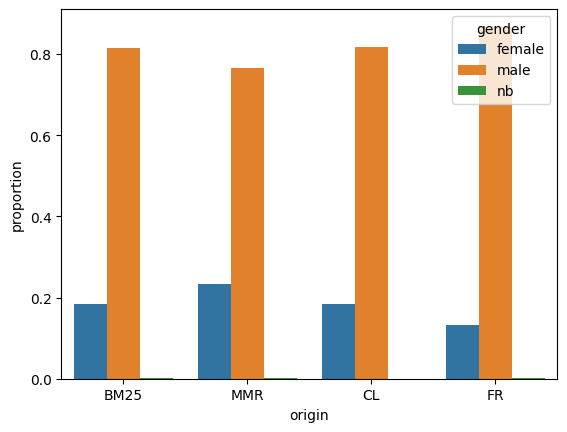

In [353]:
import seaborn as sns
bars = sns.barplot(df, x="origin", y="proportion", hue="gender")
fig = bars.get_figure()
fig.savefig("bars.png") 